# Tutorial - word2vec using pytorch

This notebook introduces how to implement the NLP technique, so-called word2vec, using pytorch. The main goal of word2vec is to build a word embedding, i.e. latent and semantic free representation of word in a continuous space.

In [ ]:
import re
import nltk
nltk.download('brown')
import itertools

from nltk.corpus import brown

corpus = []
for cat in brown.categories():
    for text_id in brown.fileids(cat):
        raw_text = list(itertools.chain(*brown.sents(text_id)))
        text = ' '.join(raw_text)
        text = text.lower()
        text.replace('\n', ' ')
        text = re.sub('[^a-z ]+', '',text)
        corpus.append([w for w in text.split() if w != ''])

[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\t158185\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!


In [ ]:
corpus[0][:5]

['dan', 'morgan', 'told', 'himself', 'he']

In [ ]:
from fastai2.text.all import *
from torch.utils.data import Dataset
from torch.nn.modules.loss import *

# Subsampling of frequent words

In [ ]:
class DataReader:
    NEGATIVE_TABLE_SIZE = 1e8
    
    def __init__(self, corpus, min_count=3):
        self.negatives=[]
        self.discards=[]
        self.negpos=0
        
        self.word2id=dict()
        self.id2word=dict()
        self.sentences_count = 0
        self.token_count = 0
        self.word_frequency=dict()
        self.corpus = corpus
        self.create_freq_table(corpus, min_count)
        self.init_table_discards()
        self.init_table_negatives()
    
    def __len__(self):
        return len(self.corpus)
    
    def create_freq_table(self, corpus, min_count):
        word_counts = dict(Counter(list(itertools.chain(*corpus))))
        
        wid=0
        total_count = 0
        for w,c in word_counts.items():
            if c < min_count:
                continue
            self.word2id[w] = wid
            self.id2word[wid] = w
            self.word_frequency[wid] = c
            wid+=1
            total_count +=c
        self.total_count = total_count
        print("Total embeddings "+ str(len(self.word2id)))
    
    def init_table_discards(self):
        t = 0.001
        f = np.array(list(self.word_frequency.values())) / self.total_count
        self.discards = np.sqrt(t/f)+ (t/f)
        
    def init_table_negatives(self):
        pow_frequency = np.array(list(self.word_frequency.values())) ** 0.5
        word_pow = sum(pow_frequency)

        ratio = pow_frequency / word_pow
        
        count = np.round(ratio * DataReader.NEGATIVE_TABLE_SIZE)
        for wid, c in enumerate(count):
            self.negatives += [self.id2word[wid]] * int(c)
        self.negatives = np.array(self.negatives)
        
        np.random.shuffle(self.negatives)
    
    def create_training_data(self, window_size=5):
        training_data = []
        for text in corpus:
            words = [ w for w in text if w in self.word2id and np.random.rand() < self.discards[self.word2id[w]]]
            boundary = np.random.randint(1, window_size)
            for i, u in enumerate(words):
                for j , v in enumerate(words[max(i-boundary, 0): i+boundary]):
                    if u != v:
                        training_data.append([u,v, self.get_negatives(u, window_size)])
            
        return training_data
    
    def get_negatives(self, target, size=5):
        response = self.negatives[self.negpos:self.negpos+size]
        self.negpos = (self.negpos + size) % len(self.negatives)
        if len(response) != size:
            return np.concatenate((response, self.negatives[0:self.negpos]))
        return response

    
    def save(self, output_dir = Path('./output')):
        
        pickle.dump(list(dr.word2id.keys()), open(output_dir/'vocab.dat','wb'))
        pickle.dump(dr.id2word, open(output_dir/'id2word.dat','wb'))
        pickle.dump(dr.word2id, open(output_dir/'word2id.dat','wb'))
        pickle.dump(dr.create_training_data(), open(output_dir/'train.dat','wb'))
        
    def load(self, input_dir = Path('./output')):
        vocab = pickle.load(open(output_dir/'vocab.dat','rb'))
        id2word = pickle.load(open(output_dir/'id2word.dat','rb'))
        word2id = pickle.load(open(output_dir/'word2id.dat','rb'))
        train = pickle.load(open(output_dir/'train.dat','rb'))

        
        return {'vocab': vocab, 'id2word': id2word, 'word2id': word2id, 'train': train}


# Building Dataset

Word2vec is a bag of words model. For each word of the dataset, we need to extract the context words, i.e. neighboring words in a certain window of fixed length. For example, in the following sentence:

* My cat is lazy, it sleeps all day long

If we consider the target word *lazy* and choose the window of size 2, then context words are cat, is , it and sleeps

In [ ]:
class Word2VecDataset(Dataset):
    def __init__(self, corpus, window_size):
        self.data_reader = DataReader(corpus)
        self.training_data = self.data_reader.create_training_data(window_size)
        self.window_size = window_size
        self.word2id = self.data_reader.word2id
        
    def __len__(self):
        return len(self.training_data)
    
    def __getitem__(self, idx):
        return ( self.word2id[self.training_data[idx][0]], 
                    self.word2id[self.training_data[idx][1]], 
                    [self.word2id[v] for v in self.training_data[idx][2]],
                    [1, *[0 for i in range(self.window_size)]]
               )

        
    @staticmethod
    def collate(batches):
        all_u = [items[0] for items in batches if len(items) > 0]
        all_v = [items[1] for items in batches if len(items) > 0]
        all_neg_v = [items[2] for items in batches  if len(items) > 0]
        target = [items[3] for items in batches if len(items) > 0]
        
        # need to create 
        return (torch.cuda.LongTensor(all_u), 
            torch.cuda.LongTensor(all_v), 
            torch.cuda.LongTensor(all_neg_v), 
            torch.cuda.LongTensor(target))


In [ ]:
wv = Word2VecDataset(corpus, 5)

Total embeddings 20026


In [ ]:
len(wv)

2939493

# Train / test split

We can split the pytorch dataset using indices or sampler. 

## Using indices

In [ ]:
train_size = int(0.8 * len(wv))
test_size = len(wv) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(wv, [train_size, test_size])

train_loader = torch.utils.data.DataLoader(wv, batch_size=16, collate_fn=Word2VecDataset.collate )
validation_loader = torch.utils.data.DataLoader(wv, batch_size=16 )

## Using sampler

In [ ]:
from torch.utils.data.sampler import SubsetRandomSampler

shuffle_dataset=True
random_seed=23
valid_size = 0.2


num_train = len(wv)
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train))

train_idx, valid_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)


if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
    
    
train_loader = torch.utils.data.DataLoader(wv, batch_size=16, 
                                           sampler=train_sampler, collate_fn=Word2VecDataset.collate,drop_last=True)
validation_loader = torch.utils.data.DataLoader(wv, batch_size=16,
                                                sampler=valid_sampler,collate_fn=Word2VecDataset.collate, drop_last=True)

# Testing

In [ ]:
batch = next(iter(train_loader)); batch

(tensor([ 1265, 10904,   369,   201,  4107,   131, 12724,  2121,  2054,  5581,
          3377,   187,   466,  9106,  1604,    70], device='cuda:0'),
 tensor([  430,  9059,     2,   944,   563, 19259,  1624,  9007, 10148,   592,
           268,   542, 11417,  1904,  1546,   531], device='cuda:0'),
 tensor([[16857, 11370,  3431,  9769, 17971],
         [ 7772,  7150,  2935,  2286,  4203],
         [ 1434, 10702,  3234,  1763, 17753],
         [20009,  2065,   767,  6596,  4792],
         [  856,  1297,  4403,   192, 11634],
         [ 6454,  6015, 13197,     4,   249],
         [ 3500,    13, 13498,    83, 13484],
         [13456, 15987, 10941,  4416,  5745],
         [ 2060, 12211,   607, 19212,   482],
         [ 7989, 15806,   296,  5057,   395],
         [   22,   172, 15652,    86,   313],
         [ 3715, 12709,  4921,  1215,   489],
         [ 2165, 10409,  9309, 13156,  1701],
         [ 4621,  4006, 17471,    12,   208],
         [13351,    23,  1600, 12324, 19626],
         [  

# The network

Now we jump into neural network. How can we build the network using the training data above

In [ ]:
import torch
import torch.nn as nn
import torch.autograd as autograd
import torch.optim as optim
import torch.nn.functional as F
from torch.nn import init


In [ ]:
class Word2Vec2(nn.Module):
    def __init__(self, embedding_size, vocab_size):
        super(Word2Vec2, self).__init__()
        self.u_embeddings = nn.Embedding(vocab_size, embedding_size)
        self.v_embeddings = nn.Embedding(vocab_size, embedding_size)
        self.embedding_size = embedding_size
        
        initrange = 1.0 / embedding_size
        init.uniform_(self.u_embeddings.weight.data, -initrange, initrange)
        init.constant_(self.v_embeddings.weight.data, 0)
        
    def forward(self, pos_u, pos_v, neg_v):
        emb_u = self.u_embeddings(pos_u)
        emb_v = self.v_embeddings(pos_v)
        emb_neg_v = self.v_embeddings(neg_v)
        
        score = torch.sum(torch.mul(emb_u, emb_v), dim=1)
        score = torch.clamp(score, max=10, min=-10).unsqueeze(1)                # 16 shape size
        #print(-F.logsigmoid(score))
        neg_score = torch.bmm(emb_neg_v, emb_u.unsqueeze(2)).squeeze()
        neg_score = torch.clamp(neg_score,max=10, min=-10)
        #print(-F.logsigmoid(-neg_score))
        try:
            return torch.cat((F.sigmoid(score), F.sigmoid(neg_score)), dim=1)
        except:
            return torch.cat((F.sigmoid(score), F.sigmoid(neg_score).unsqueeze(0)),dim=1)
        
    def save_embedding(self, id2word, file_name):
        embedding = self.u_embeddings.weight.cpu().data.numpy()
        with open(file_name, 'w') as f:
            f.write('%d %d\n' % (len(id2word), self.embedding_size))
            for wid, w in id2word.items():
                e = ' '.join(map(lambda x: str(x), embedding[wid]))
                f.write('%s %s\n' % (w, e))

In [ ]:
class Word2Vec(nn.Module):
    def __init__(self, embedding_size, vocab_size):
        super(Word2Vec, self).__init__()
        self.u_embeddings = nn.Embedding(vocab_size, embedding_size)
        self.v_embeddings = nn.Embedding(vocab_size, embedding_size)
        
        initrange = 1.0 / embedding_size
        init.uniform_(self.u_embeddings.weight.data, -initrange*2, initrange*2)
        init.constant_(self.v_embeddings.weight.data, 0)
        
    def forward(self, pos_u, pos_v, neg_v):
        emb_u = self.u_embeddings(pos_u)
        emb_v = self.v_embeddings(pos_v)
        emb_neg_v = self.v_embeddings(neg_v)
        
        score = torch.sum(torch.mul(emb_u, emb_v), dim=1)
        score = torch.clamp(score, max=10, min=-10)
        score = -F.logsigmoid(score)   # 16
        #print(score)
        neg_score = torch.bmm(emb_neg_v, emb_u.unsqueeze(2)).squeeze()
        neg_score = torch.clamp(neg_score,max=10, min=-10)      # 16X
        neg_score = -F.logsigmoid(-neg_score)  # this is same as F.log(1- F.sigmoid(1-neg_score))
        #print(neg_score)
        neg_score = torch.sum(neg_score, dim=1)
        #print(score+neg_score)
        return torch.mean(score + neg_score)
    
    
    def save_embedding(self, id2word, file_name):
        embedding = self.u_embeddings.weight.cpu().data.numpy()
        with open(file_name, 'w') as f:
            f.write('%d %d\n' % (len(id2word), self.embedding_size))
            for wid, w in id2word.items():
                e = ' '.join(map(lambda x: str(x), embedding[wid]))
                f.write('%s %s\n' % (w, e))

In [ ]:
model = Word2Vec(embedding_size=300, vocab_size=len(wv.word2id)).cuda()

In [ ]:
model(batch[0], batch[1], batch[2])

tensor(4.1589, device='cuda:0', grad_fn=<MeanBackward0>)

In [ ]:
model = Word2Vec2(embedding_size=300, vocab_size=len(wv.word2id)).cuda()

In [ ]:
def binary_cross_entropy(pred, y): 
    return -(pred.log()*y + (1-y)*(1-pred).log()).sum(axis=1).mean()

In [ ]:
pred = model(batch[0], batch[1], batch[2])
binary_cross_entropy(pred, batch[3])

tensor(4.1589, device='cuda:0', grad_fn=<NegBackward>)

# Use fastai to run

In [ ]:
model = Word2Vec2(embedding_size=100, vocab_size=len(wv.word2id)).cuda()

In [ ]:
dbunch = DataBunch(train_loader, validation_loader).cuda()

In [ ]:
learn = Learner(dbunch,model, loss_func=binary_cross_entropy, opt_func=partial(Adam, wd=0.1, eps=1e-3)).to_fp16()

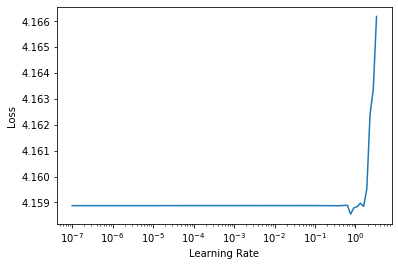

In [ ]:

learn.lr_find()

In [ ]:
learn.fit_one_cycle(1,lr_max=5*10e-3,wd=1.0)

epoch,train_loss,valid_loss,time
0,4.158871,4.157591,46:04


In [ ]:
learn.cbs

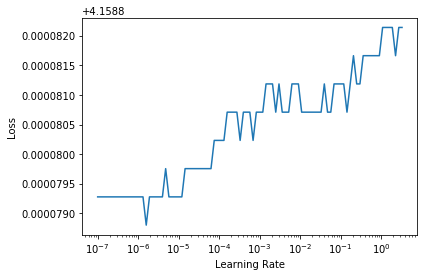

In [ ]:
learn.lr_find()

In [ ]:
learn.recorder.plot_lr_find()

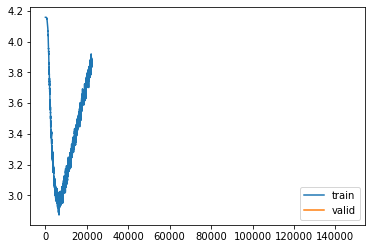

In [ ]:
learn.recorder.plot_loss()

In [ ]:
from gensim.models import KeyedVectors
model = KeyedVectors.load_word2vec_format("word_embeddings.txt")

In [ ]:
model.most_similar("mother")

C:\Users\t158185\AppData\Local\Continuum\anaconda3\lib\site-packages\gensim\models\keyedvectors.py:2377: RuntimeWarning: divide by zero encountered in true_divide
  return (m / dist).astype(REAL)


[('former', 0.43849676847457886),
 ('ballot', 0.4359632432460785),
 ('peter', 0.4338271915912628),
 ('howard', 0.42440634965896606),
 ('agriculture', 0.42155084013938904),
 ('earlier', 0.41551852226257324),
 ('miller', 0.41462981700897217),
 ('designs', 0.40562668442726135),
 ('toll', 0.4046321511268616),
 ('king', 0.403326153755188)]

In [ ]:
model.most_similar("queen")

[('midnight', 0.594296932220459),
 ('powell', 0.5909057259559631),
 ('implements', 0.5603249669075012),
 ('dusseldorf', 0.5540580749511719),
 ('festivities', 0.5511586666107178),
 ('wage', 0.5501848459243774),
 ('merit', 0.543738067150116),
 ('succeed', 0.5423159003257751),
 ('independent', 0.5349534153938293),
 ('talked', 0.5343658328056335)]

In [ ]:
import gensim, logging

In [ ]:
model = gensim.models.Word2Vec(min_count=1,size=100,window=3,sg=0,negative=5)
model.build_vocab(corpus)


In [ ]:
model.train(corpus, total_examples=len(corpus), epochs=30)

(2034778, 2610120)

In [ ]:
model.init_sims(replace=True)


In [ ]:
model.most_similar('happy')

C:\Users\t158185\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('written', 0.9856124520301819),
 ('possibly', 0.9807665944099426),
 ('anywhere', 0.9805192947387695),
 ('losing', 0.9757179617881775),
 ('difference', 0.9738084077835083),
 ('mobile', 0.9729167222976685),
 ('engineers', 0.9717029333114624),
 ('heritage', 0.9707537889480591),
 ('doing', 0.9704898595809937),
 ('taking', 0.969912588596344)]